In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/drive/MyDrive/DataMining/project/optiver-trading-at-the-close/train.csv')

In [3]:
df_copy = df.copy()

In [4]:
df_copy.head(8)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,1962.72,1.000635,5647.65,1.0,6.779432,0,0_0_5
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819,0,0_0_6
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801,0,0_0_7


In [5]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [6]:
nan_counts = df_copy.isna().sum()
print(nan_counts)

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64


drop the data with target missing

In [48]:
df_copy.dropna(subset=['target'], inplace=True)

In [60]:
nan_counts = df_copy.isna().sum()
print(nan_counts)

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 132
imbalance_buy_sell_flag          0
reference_price                132
matched_size                   132
far_price                  2894254
near_price                 2857092
bid_price                      132
bid_size                         0
ask_price                      132
ask_size                         0
wap                            132
target                           0
time_id                          0
row_id                           0
dtype: int64


In [53]:
def check_nan_attribute(attribute, columns_to_exclude):
  # Initialize an empty DataFrame to store NaN counts for each day and column
  nan_counts = pd.DataFrame(columns=df_copy.columns.difference(columns_to_exclude))

  for i in range(df_copy[attribute].max() + 1):
    attribute_df = df_copy[df_copy[attribute] == i]
    na_count = attribute_df.drop(columns=columns_to_exclude).isna().sum()
    nan_counts = nan_counts.append(na_count, ignore_index=True)
  plt.figure(figsize=(20, 6))
  for column in nan_counts.columns:
      plt.plot(range(df_copy[attribute].max() + 1), nan_counts[column], marker='o', linestyle = 'None', label=column)

  plt.title('Count of NaN Values in Different Columns for Each' + attribute)
  plt.xlabel(attribute)
  plt.ylabel('Count of NaN Values')
  plt.legend()
  plt.show()




<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is dep

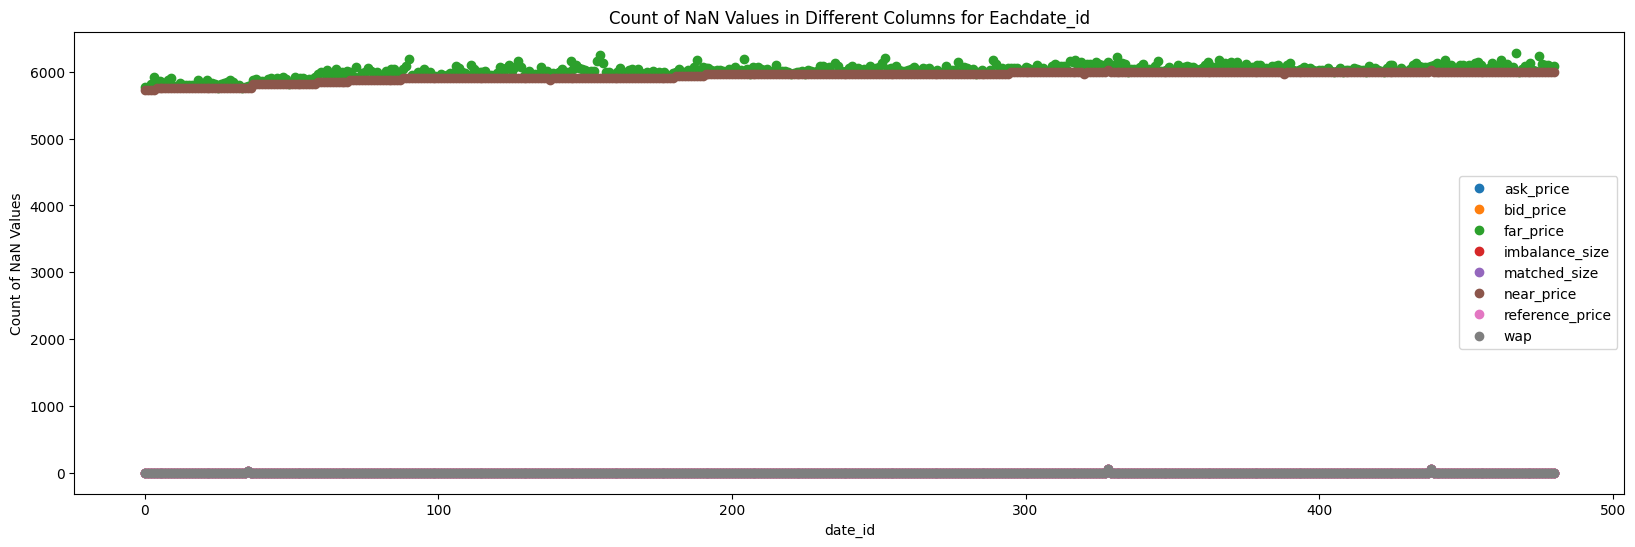

In [58]:
columns_to_exclude = ['stock_id', 'date_id', 'target', 'seconds_in_bucket', 'imbalance_buy_sell_flag', 'bid_size', 'ask_size', 'time_id', 'row_id']
check_nan_attribute('date_id', columns_to_exclude)


<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is dep

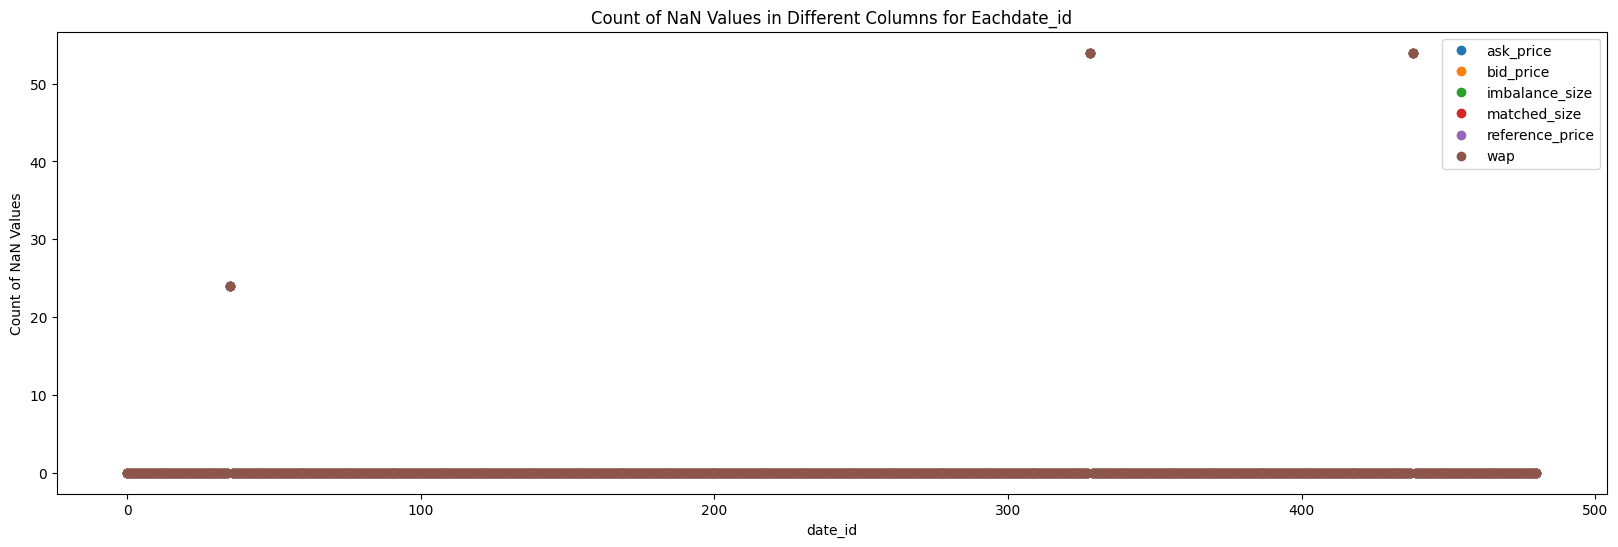

In [55]:
columns_to_exclude += ['near_price', 'far_price']
check_nan_attribute('date_id', columns_to_exclude)

<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is dep

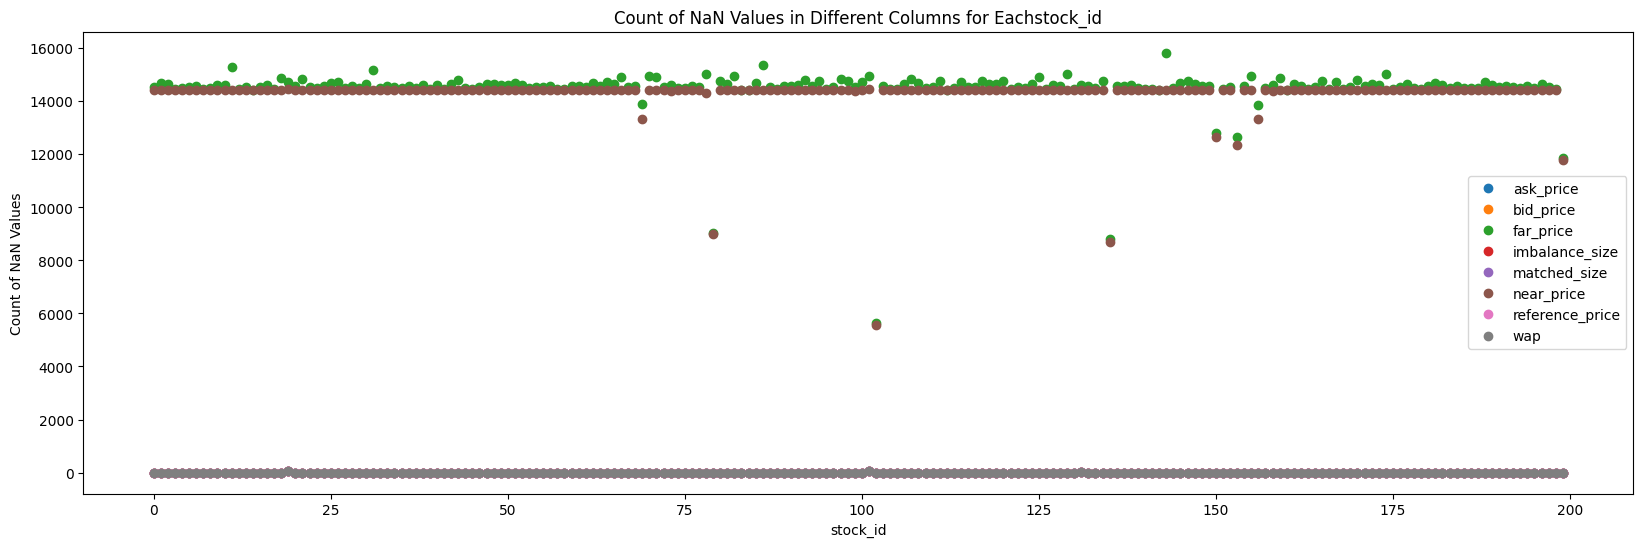

In [56]:
columns_to_exclude = ['stock_id', 'date_id', 'target', 'seconds_in_bucket', 'imbalance_buy_sell_flag', 'bid_size', 'ask_size', 'time_id', 'row_id']
check_nan_attribute('stock_id', columns_to_exclude)

<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-53-14cf87b72785>:8: FutureWarning: The frame.append method is dep

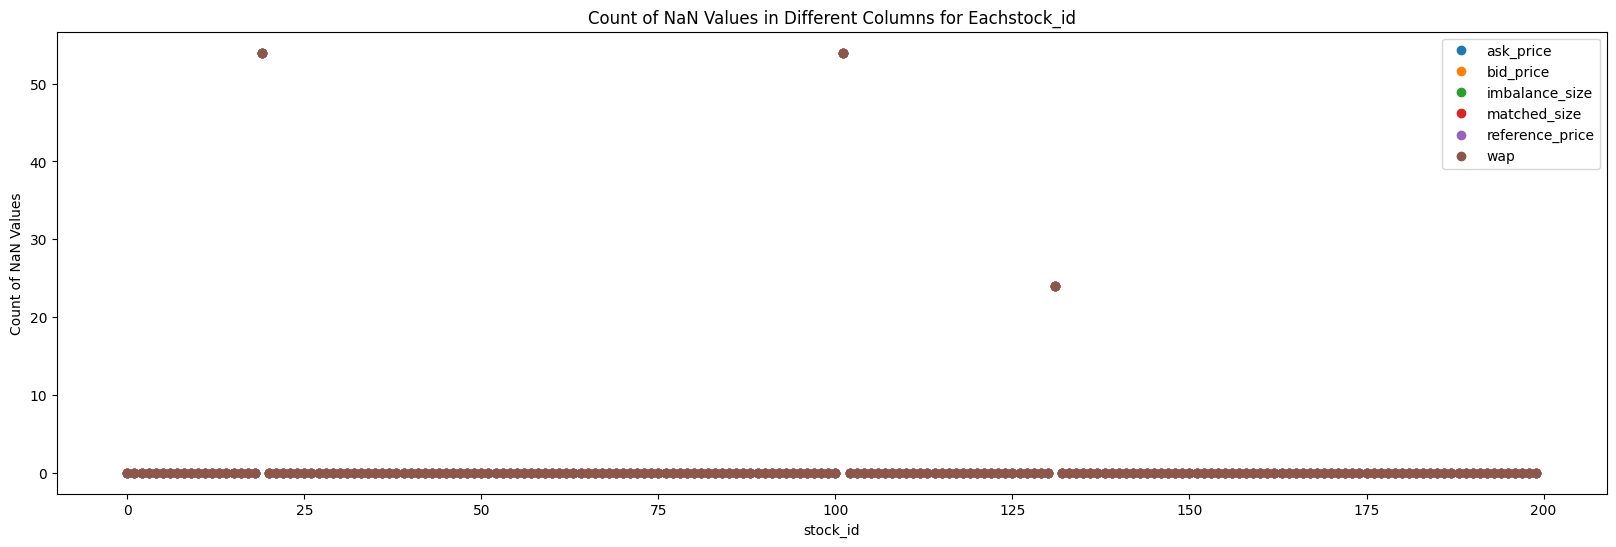

In [57]:
columns_to_exclude += ['near_price', 'far_price']
check_nan_attribute('stock_id', columns_to_exclude)

There are missing data on specific date and stock.
Let's check if there are some stocks missing data on some days entirely.

In [109]:
# Assuming df_copy is your DataFrame
selected_columns = ['wap', 'reference_price', 'bid_price', 'ask_price', 'matched_size', 'imbalance_size']

nan_rows = df_copy[df_copy[selected_columns].isnull().any(axis=1)]
print("stocks has missing values: " + str(nan_rows['stock_id'].unique()))

stock131 = nan_rows[nan_rows['stock_id'] == 131]
print("stock 131 has missing " + str(stock131['date_id'].count()) + " data on date " + str(stock131['date_id'].unique())+ " in time frame from " + str(stock131['time_id'].iloc[0]) + " to " + str(stock131['time_id'].iloc[-1]))
stock19 = nan_rows[nan_rows['stock_id'] == 19]
print("stock 19 has missing " + str(stock19['date_id'].count()) + " data on date " + str(stock19['date_id'].unique())+ " in time frame from " + str(stock19['time_id'].iloc[0]) + " to " + str(stock19['time_id'].iloc[-1]))
stock101 = nan_rows[nan_rows['stock_id'] == 101]
print("stock 101 has missing " + str(stock101['date_id'].count()) + " data on date " + str(stock101['date_id'].unique()) + " in time frame from " + str(stock101['time_id'].iloc[0]) + " to " + str(stock101['time_id'].iloc[-1]))


stocks has missing values: [131 101  19]
stock 131 has missing 24 data on date [35] in time frame from 1955 to 1978
stock 19 has missing 54 data on date [438] in time frame from 24091 to 24144
stock 101 has missing 54 data on date [328] in time frame from 18041 to 18094


Check correlation between features for making guesses in missing values

<ipython-input-59-04ca8a572d85>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_copy.corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')


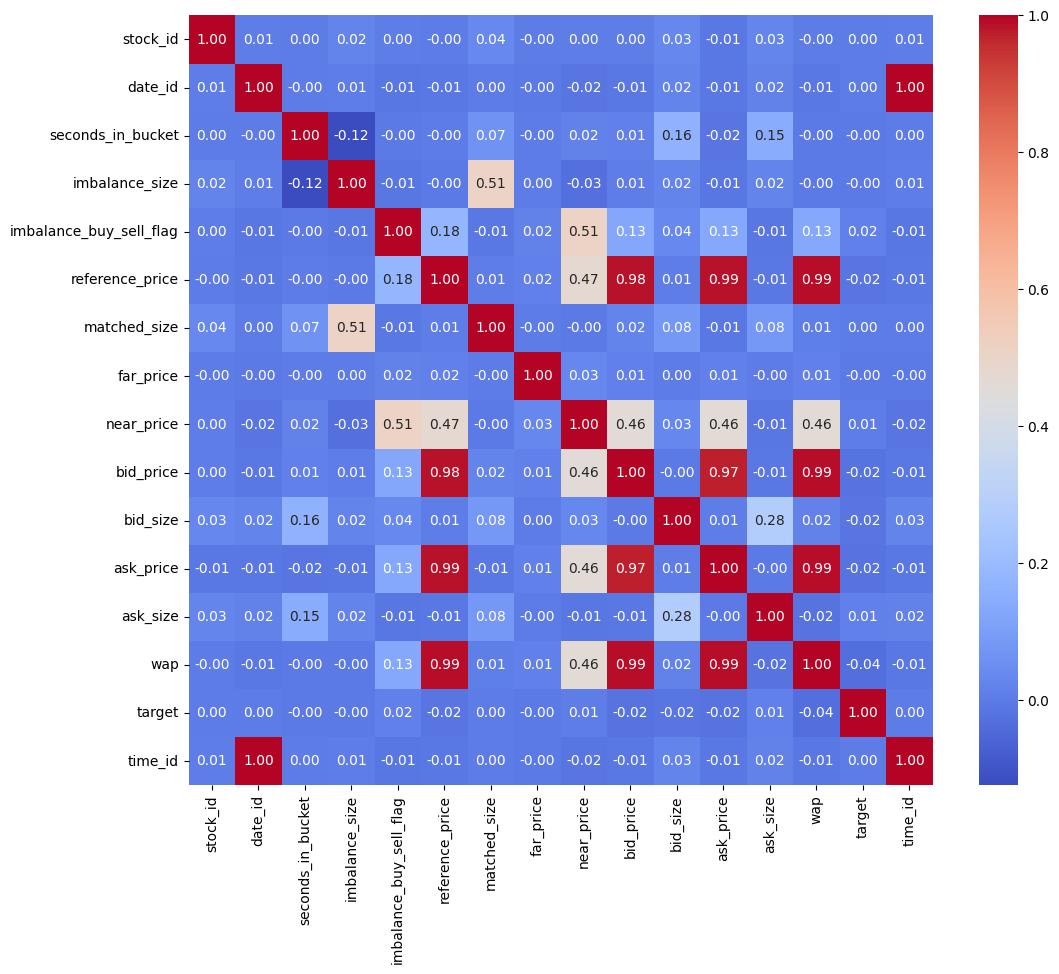

In [59]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_copy.corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.show()

Since the atrributes that has high correlation are the missing ones, i cannot use for filling the values.